In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to your leather dataset in Google Drive
# (Put the correct folder name you used)
leather_data_path = "/content/drive/MyDrive/Mvtec/leather"

print("Local data import complete.")
print("Dataset path:", leather_data_path)

Mounted at /content/drive
Local data import complete.
Dataset path: /content/drive/MyDrive/Mvtec/leather


In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
print("Torch version:", torch.__version__)


Torch version: 2.8.0+cu126


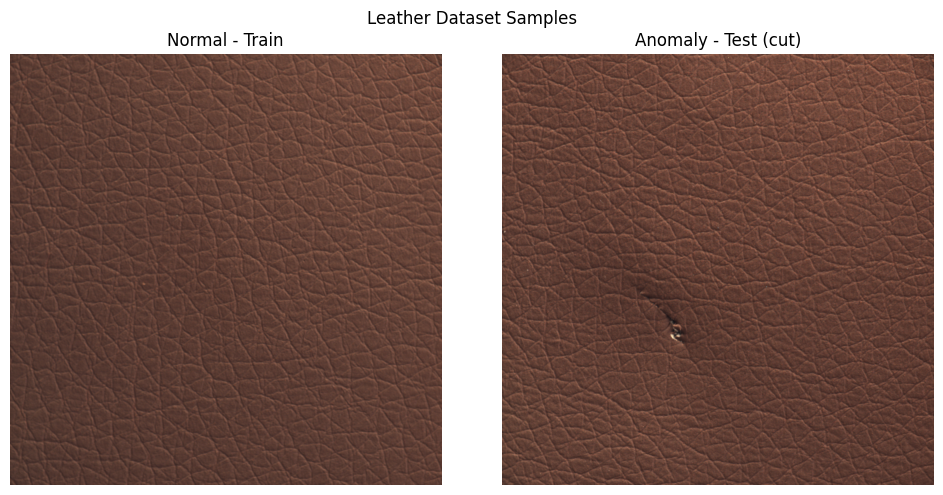

In [ ]:


# List some sample images from leather (normal & anomaly)
normal_images = glob.glob(os.path.join(leather_data_path, 'train/good/*.png'))
anomaly_images = glob.glob(os.path.join(leather_data_path, 'test/cut/*.png'))

# Visualize a normal and an anomalous image
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

normal_img = Image.open(normal_images[0])
anomaly_img = Image.open(anomaly_images[0])

axs[0].imshow(normal_img)
axs[0].set_title('Normal - Train')
axs[0].axis('off')

axs[1].imshow(anomaly_img)
axs[1].set_title('Anomaly - Test (cut)')
axs[1].axis('off')

plt.suptitle('Leather Dataset Samples')
plt.tight_layout()
plt.show()


In [ ]:



# Most DINOv3 models expect 224x224 or 256x256 and ImageNet normalization
transform = T.Compose([
    T.Resize((224, 224)),  # Change size as needed for your backbone
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225],   # ImageNet std
    ),
])

# Load and preprocess one normal and one anomaly image
normal_tensor = transform(normal_img).unsqueeze(0)  # shape [1, 3, H, W]
anomaly_tensor = transform(anomaly_img).unsqueeze(0)

print("Preprocessed normal image shape:", normal_tensor.shape)
print("Preprocessed anomaly image shape:", anomaly_tensor.shape)


Preprocessed normal image shape: torch.Size([1, 3, 224, 224])
Preprocessed anomaly image shape: torch.Size([1, 3, 224, 224])


In [ ]:
!pip install transformers --quiet
!huggingface-cli logi
from transformers import AutoImageProcessor, AutoModel
import torch

# Choose a DINOv3 model; adjust as needed for your experiment
pretrained_model_name = "facebook/dinov3-vitb16-pretrain-lvd1689m"

# Load processor and model (auto device selection)
processor = AutoImageProcessor.from_pretrained(pretrained_model_name)
model = AutoModel.from_pretrained(pretrained_model_name, device_map="auto")

# If you preprocessed manually, you can pass tensors directly (skip processor if unwanted)
# Otherwise, use HF processor to handle input (uncomment below for processor-driven)
# inputs_normal = processor(images=normal_img, return_tensors="pt").to(model.device)
# inputs_anomaly = processor(images=anomaly_img, return_tensors="pt").to(model.device)

# If using manual transform (from previous cell):
inputs_normal = {'pixel_values': normal_tensor.to(model.device)}
inputs_anomaly = {'pixel_values': anomaly_tensor.to(model.device)}

# Extract features without gradients for efficiency
with torch.inference_mode():
    outputs_normal = model(**inputs_normal)
    outputs_anomaly = model(**inputs_anomaly)

# For DINOv3 transformer models, patch embeddings are often in last_hidden_state
features_normal = outputs_normal.last_hidden_state.squeeze(0)  # [Num_patches, feature_dim]
features_anomaly = outputs_anomaly.last_hidden_state.squeeze(0)

print("Patch features (normal):", features_normal.shape)
print("Patch features (anomaly):", features_anomaly.shape)

usage: huggingface-cli <command> [<args>]
huggingface-cli: error: argument {download,upload,repo-files,env,login,whoami,logout,auth,repo,lfs-enable-largefiles,lfs-multipart-upload,scan-cache,delete-cache,tag,version,upload-large-folder}: invalid choice: 'logi' (choose from download, upload, repo-files, env, login, whoami, logout, auth, repo, lfs-enable-largefiles, lfs-multipart-upload, scan-cache, delete-cache, tag, version, upload-large-folder)


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/facebook/dinov3-vitb16-pretrain-lvd1689m.
401 Client Error. (Request ID: Root=1-6918c581-09593ccb7ef5e7d559f5fd04;b6e63aa2-abe0-4690-a5dd-d17c13c61dbe)

Cannot access gated repo for url https://huggingface.co/facebook/dinov3-vitb16-pretrain-lvd1689m/resolve/main/preprocessor_config.json.
Access to model facebook/dinov3-vitb16-pretrain-lvd1689m is restricted. You must have access to it and be authenticated to access it. Please log in.

In [ ]:
!pip install transformers --quiet
# The huggingface-cli login is not strictly necessary for public models, but keeping it won't harm.
#!hf auth login
from transformers import AutoImageProcessor, AutoModel
import torch

# Choose a DINO model that is publicly available
pretrained_model_name = "facebook/dino-vits16"

# Load processor and model (auto device selection)
processor = AutoImageProcessor.from_pretrained(pretrained_model_name)
model = AutoModel.from_pretrained(pretrained_model_name, device_map="auto")

# If using manual transform (from previous cell):
inputs_normal = {'pixel_values': normal_tensor.to(model.device)}
inputs_anomaly = {'pixel_values': anomaly_tensor.to(model.device)}

# Extract features without gradients for efficiency
with torch.inference_mode():
    outputs_normal = model(**inputs_normal)
    outputs_anomaly = model(**inputs_anomaly)

# For DINO models, patch embeddings are often in last_hidden_state
features_normal = outputs_normal.last_hidden_state.squeeze(0)  # [Num_patches, feature_dim]
features_anomaly = outputs_anomaly.last_hidden_state.squeeze(0)

print("Patch features (normal):", features_normal.shape)
print("Patch features (anomaly):", features_anomaly.shape)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Patch features (normal): torch.Size([197, 384])
Patch features (anomaly): torch.Size([197, 384])


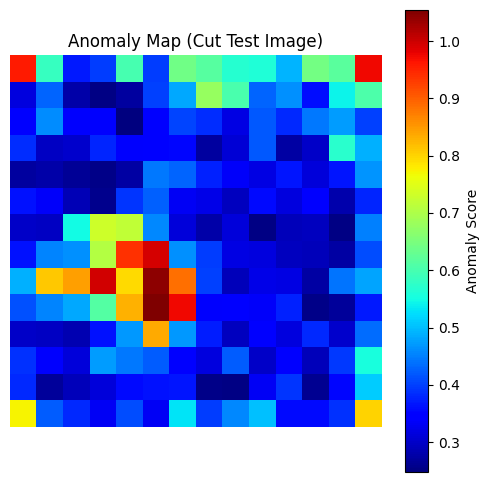

In [ ]:
import torch

# Cosine similarity example
cos = torch.nn.CosineSimilarity(dim=1)

# Compare each patch of the anomaly image to the mean of all normal patches (reference embedding)
ref_patch = features_normal.mean(dim=0, keepdim=True)
similarity_map = cos(features_anomaly, ref_patch)

# Convert similarity to anomaly score (lower similarity = higher anomaly)
anomaly_scores = 1.0 - similarity_map  # Scores in [0, 2], higher = more anomalous

# Reshape scores for visualization (patch grid size, e.g. 14x14 for ViT-S/ViT-B, adjust as needed)
# Exclude the CLS token (first element) for reshaping into a grid
num_patches_spatial = features_anomaly.shape[0] - 1 # Remove CLS token
patch_grid_size = int(num_patches_spatial**0.5)
anomaly_scores_vis = anomaly_scores[1:].view(patch_grid_size, patch_grid_size).cpu().numpy() # [1:] to remove CLS token

# Plot the anomaly map
plt.figure(figsize=(6, 6))
plt.title("Anomaly Map (Cut Test Image)")
plt.imshow(anomaly_scores_vis, cmap="jet")
plt.colorbar(label="Anomaly Score")
plt.axis('off')
plt.show()